# <div align="center">Recommender System using Auto Encoder</div>

Create a recommender system to recommend the movie based on user's rating using Auto Encoder.

- Auto Encoder: Architecture Overview
  - Visible Input Nodes -> Encoding -> Hidden Nodes -> Decoding -> Visible Output Nodes
  - 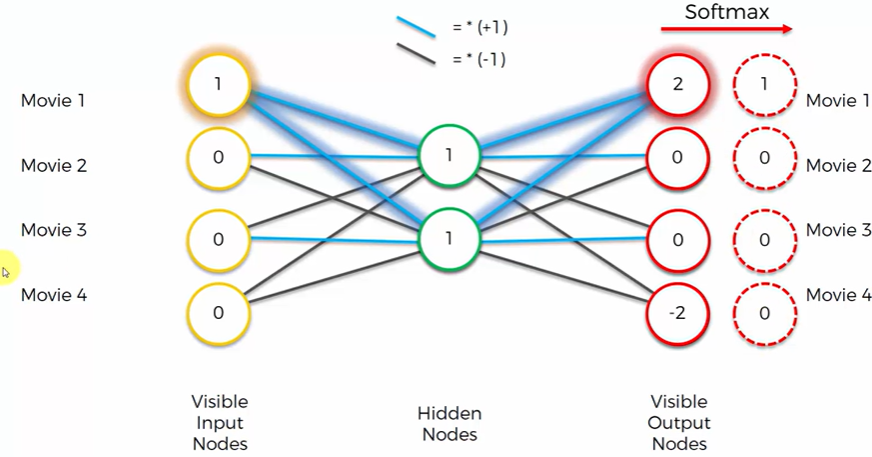
- Auto Encoder can be used for
  - Feature Detection
  - Encoding the features
- Hidden Layers: If we have hidden nodes greater than or equal to input node then info can propagate from input to output and hidden layer. To solve it we can different approaches.
- Stacked AutoEncoder: It has 2 encoding layer and 1 decoding layer.

## Traning a Auto Encoder
- Steps performed:
  - Step 1: We start with an array where the lines (the observations) correspond to the users and the columns (the features) correspond to the movies. Each cell (u, i) contains the rating (from 1 to 5, 0 if no rating) of the movie i by the user u.
  - Step 2: The first user goes into the network. The input vector x = (r₁, r₂, ..., rₘ) contains all its ratings for all the movies.
  - Step 3: The input vector x is encoded into a vector z of lower dimensions by a mapping function f (e.g., sigmoid function): z = f(Wx+b)z, where W is the vector of input weights and b is the bias.
  - Step 4: z is then decoded into the output vector y of same dimensions as x, aiming to replicate the input vector x.
  - Step 5: The reconstruction error d(x,y) = ∣∣x−y∣∣ is computed. The goal is to minimize it.
  - Step 6: Back-Propagation: From right to left, the error is back-propagated. The weights are updated according to how much they are responsible for the error. The learning rate decides by how much we update the weights.
  - Step 7: Repeat Steps 1 to 6 and update the weights after each observation (Reinforcement Learning) Or Repeat Steps 1 to 6 but update the weights only after a batch of observations (Batch Learning).
  - Step 8: When the whole training set has passed through the ANN, that makes an epoch. Redo more epochs.

## Importing the libraries

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

## Importing the dataset

In [41]:
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1') # MovieID::Title::Genres
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1') # UserID::Gender::Age::Occupation::Zip-code
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1') # UserID::MovieID::Rating::Timestamp

## Preparing the training set and the test set

In [57]:
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')

In [58]:
training_set.head()

,1,1.1,5,874965758
0,1,2,3,876893171
1,1,3,4,878542960
2,1,4,3,876893119
3,1,5,3,889751712
4,1,7,4,875071561


In [59]:
training_set = np.array(training_set, dtype = 'int') # training_set will be the list of list(UserID::MovieID::Rating::Timestamp)
test_set = np.array(test_set, dtype = 'int')

In [60]:
print(training_set)

[[        1         2         3 876893171]
 [        1         3         4 878542960]
 [        1         4         3 876893119]
 ...
 [      943      1188         3 888640250]
 [      943      1228         3 888640275]
 [      943      1330         3 888692465]]


## Getting the number of users and movies

In [61]:
# We need no of movies and users because we need to create matrices with all the user and corresponding rating for the movie 
# if user did not rate movie then we will mark as 0
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))
nb_users, nb_movies

(943, 1682)

## Converting the data into an array with users in lines and movies in columns

In [62]:
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0] == id_users] # list of moviesid for the userid
        id_ratings = data[:,2][data[:,0] == id_users] # list of ratings for the userid
        ratings = np.zeros(nb_movies) # initialized as a zero array of size nb_movies (the total number of movies)
        ratings[id_movies - 1] = id_ratings # Convert 1 based in indexed in list to 0 based indexed in array
        new_data.append(list(ratings)) # Get the list if rating for userid 
    return new_data
training_set = convert(training_set)
test_set = convert(test_set)

## Converting the data into Torch tensors
- Converting a NumPy array to a tensor is essential in machine learning workflows because most modern ML frameworks (like TensorFlow and PyTorch) operate natively with tensors, not with NumPy arrays. Tensors enable hardware acceleration (like GPU computation), automatic differentiation, and efficient deployment—all vital for building and training deep learning models.

In [17]:
training_set = torch.FloatTensor(training_set) 
test_set = torch.FloatTensor(test_set)

## Creating the Architecture of the Neural Network

In [7]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

#### About Neural Network Architecture
- Why do we need class: Due to 1. Inheritance, 2. Need multiple variables and methods to make auto encoder.
- We choose Stached Auto Encoder because we have several hidden layer for auto encoder.
- __init__ function is used to initilize the object. We can consider self as auto encoder because it is the object of a SAE class. Blank will conder variable of a Module class because of inheritance.
- Process of inheritance is optimize with super function. We are using super function to use the function and classes of nn.Module. super(SAE, self).__init__() will make sure to get all the functions and classes to parent module.
- Fully Connected Layer
  - We're encoding the input vector into a shorter vector. That's will take place in the first hidden layer.
  - The first input is the number of features in the input vector and features are actually movies contains all the ratings of all the movies, so input features is nb_movies.
  - The first hidden layer of 20 neurons in the autoencoder learns features (e.g., genres like horror) through unsupervised learning, and activated neurons with higher weights help predict user ratings for similar movies.
  - fc1 and fc2 are encoding layer and fc3 and fc4 are decoding layer.
  - An activation function determines whether a neuron activates for an input, such as triggering the horror genre feature when a user gives high ratings to horror movies.
- Forward method
  - The forward function in an autoencoder performs the core action of encoding and decoding observations as they pass through the network.
  - The second function performs encoding, decoding, applies activation functions, and ultimately returns the predicted ratings vector to be compared with the actual ratings vector.
  - The second argument x is the user’s ratings input vector, which is encoded twice and decoded twice to reconstruct the final output vector.
  - The input vector x is passed through the first full connection (fc1) with a sigmoid activation, producing a 20-element encoded vector in the first hidden layer, which then becomes the new x for subsequent transformations.
- Criterion is created as an object of the MSELoss class, representing the mean squared error loss function.
- An optimizer is required, similar to Keras, to apply gradient descent and update weights at each epoch to reduce error.
  - The RMSprop optimizer requires three inputs, the first being all parameters of the autoencoder (including those tied to the Sigmoid activation), which can be accessed directly through the SAE object’s attribute.
  - The second RMSprop input is the learning rate (LR), typically set to 0.01, with decay optionally used to gradually reduce it over epochs for better convergence.

## Training the SAE

In [9]:
nb_epoch = 200
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            #train_loss += np.sqrt(loss.data[0]*mean_corrector)
            train_loss += np.sqrt(loss.item() * mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: 1.7671144364259816
epoch: 2 loss: 1.0965373959516511
epoch: 3 loss: 1.0534751105566913
epoch: 4 loss: 1.0381005220574582
epoch: 5 loss: 1.0310813722307681
epoch: 6 loss: 1.0266464016787527
epoch: 7 loss: 1.0235786926140504
epoch: 8 loss: 1.0219996263461575
epoch: 9 loss: 1.0206660384386832
epoch: 10 loss: 1.019737075670741
epoch: 11 loss: 1.0187417502499043
epoch: 12 loss: 1.018479276803486
epoch: 13 loss: 1.0175239556368603
epoch: 14 loss: 1.0176962879373832
epoch: 15 loss: 1.0171093512160099
epoch: 16 loss: 1.0168496533158393
epoch: 17 loss: 1.016821138927385
epoch: 18 loss: 1.0165262274587243
epoch: 19 loss: 1.0160982423051048
epoch: 20 loss: 1.0163276226068427
epoch: 21 loss: 1.01588345512322
epoch: 22 loss: 1.0160554873679406
epoch: 23 loss: 1.0158755337775438
epoch: 24 loss: 1.015985944391785
epoch: 25 loss: 1.0159502577964146
epoch: 26 loss: 1.0157008477108982
epoch: 27 loss: 1.0154517536492664
epoch: 28 loss: 1.0150186372065346
epoch: 29 loss: 1.0132788925301033


- About Training the SAE
  - s: Variable that will count the number of users that rated at least one movie. s is float because we are going to compute root mean square error at the end.
  - input: Since training_set_id_user is a 1D vector, it must be converted into a batch of input vectors (e.g., using Variable and reshaping) because PyTorch networks like the forward function cannot process single 1D vectors directly. In PyTorch, to create a batch of one input vector for online learning, wrap training_set(id_user) in a Variable, then use .unsqueeze(0) to add a new dimension at index 0, enabling weight updates after each observation.
  - Target is same as input vector but since we are modifying input.
  - Only purpose of introducing if condition is to optimize memory (Remove user if not rated any movie). target.data get all the rating of id_user.
  - output: A vector of predicted rating. sea object with input call forward method and return predicted rating.
  - target.require_grad: Optimization step, since we have 2 input and no need to compute gradient.
  - output(target == 0): Optimization step, where we do not want to include rating if user has not rated.
  - Criterion object is used to calculate loss.
  - The mean_corrector variable (Represents the average of the error by considering the movies that were rated) is defined as the total number of movies divided by the number of movies with non-zero ratings (with a small value added to avoid division by zero), and it ensures error averaging is computed only over rated movies, making the mean mathematically relevant.
  - Calling loss.backward() computes the gradients, indicating whether each weight should increase or decrease to minimize the loss.
  - To compute RMSE, the train loss is updated incrementally by adding the error (difference between real and predicted ratings) adjusted with the mean_corrector, and then NumPy’s square root is applied to convert the squared error into root mean squared error.
  - The optimizer’s step() method updates the weights, where backward() determines the direction of weight change, and the optimizer step decides the intensity (magnitude) of the update.

## Testing the SAE

In [11]:
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user]).unsqueeze(0)
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False
        output[target == 0] = 0
        loss = criterion(output, target)
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data*mean_corrector)
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.9609)


- If a user rates all action movies highly, the action-related feature neurons activate with strong weights to predict high ratings for unseen action movies, and these predictions are then compared with the test set ratings.